<a href="https://colab.research.google.com/github/v-IRU-s/Mini-project/blob/main/Supervised_Learning_Retail_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
predicting_the_sales_of_products_of_a_retail_chain_path = kagglehub.dataset_download('mragpavank/predicting-the-sales-of-products-of-a-retail-chain')

print('Data source import complete.')


Data source import complete.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/sample_submission.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/train_data.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/date_to_week_id_map.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/test_data.csv
/kaggle/input/predicting-the-sales-of-products-of-a-retail-chain/product_prices.csv


In [5]:
import os

# Check the content of the downloaded dataset folder
print(os.listdir(predicting_the_sales_of_products_of_a_retail_chain_path))


['sample_submission.csv', 'train_data.csv', 'date_to_week_id_map.csv', 'test_data.csv', 'product_prices.csv']


# 1. Import the libraries and files

In [6]:
import pandas as pd

# Load the CSV files using the correct path
train_data = pd.read_csv(predicting_the_sales_of_products_of_a_retail_chain_path + '/train_data.csv')
test_data = pd.read_csv(predicting_the_sales_of_products_of_a_retail_chain_path + '/test_data.csv')
date_to_week_id_map = pd.read_csv(predicting_the_sales_of_products_of_a_retail_chain_path + '/date_to_week_id_map.csv')
sample_submission = pd.read_csv(predicting_the_sales_of_products_of_a_retail_chain_path + '/sample_submission.csv')
product_prices = pd.read_csv(predicting_the_sales_of_products_of_a_retail_chain_path + '/product_prices.csv')


# 2. Merge the files into one data frame for training data

In [7]:
merged_product_df = pd.merge(product_prices,date_to_week_id_map, on=['week_id'], how='inner')
train_data = pd.merge(train_data,merged_product_df, on=['date','product_identifier','outlet'], how='inner')
train_data

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88
...,...,...,...,...,...,...,...,...,...
394995,2014-02-28,2932,33,drinks_and_food,333,Kerala,2,161,2.78
394996,2014-02-28,2935,33,drinks_and_food,333,Kerala,8,161,0.20
394997,2014-02-28,3004,33,drinks_and_food,333,Kerala,0,161,2.50
394998,2014-02-28,3008,33,drinks_and_food,333,Kerala,0,161,1.98


Converted the date attribute to date time to obtain the month of sales rather than the date as whole

In [8]:
import datetime as dt
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['month']=train_data['date'].dt.month

Drop the date attribute since we have the month and no longer need the date

In [9]:
train_data=train_data.drop(['date'],axis=1)
train_data.isna().sum()

,0
product_identifier,0
department_identifier,0
category_of_product,0
outlet,0
state,0
sales,0
week_id,0
sell_price,0
month,0


# 3. Convert the attributes into appropriate datatypes

In [10]:
##converting as category
col = ['category_of_product', 'state']
# Convert each column to category type and then access category codes
for col_name in col:
    train_data[col_name] = train_data[col_name].astype('category').cat.codes
    print(train_data[col_name])

0         2
1         2
2         2
3         2
4         1
         ..
394995    0
394996    0
394997    0
394998    0
394999    0
Name: category_of_product, Length: 395000, dtype: int8
0         1
1         1
2         1
3         1
4         1
         ..
394995    0
394996    0
394997    0
394998    0
394999    0
Name: state, Length: 395000, dtype: int8


In [11]:
train_data.dtypes

,0
product_identifier,int64
department_identifier,int64
category_of_product,int8
outlet,int64
state,int8
sales,int64
week_id,int64
sell_price,float64
month,int32


# 4. Find the correlation between the attributes to check if any of them need to be discarded

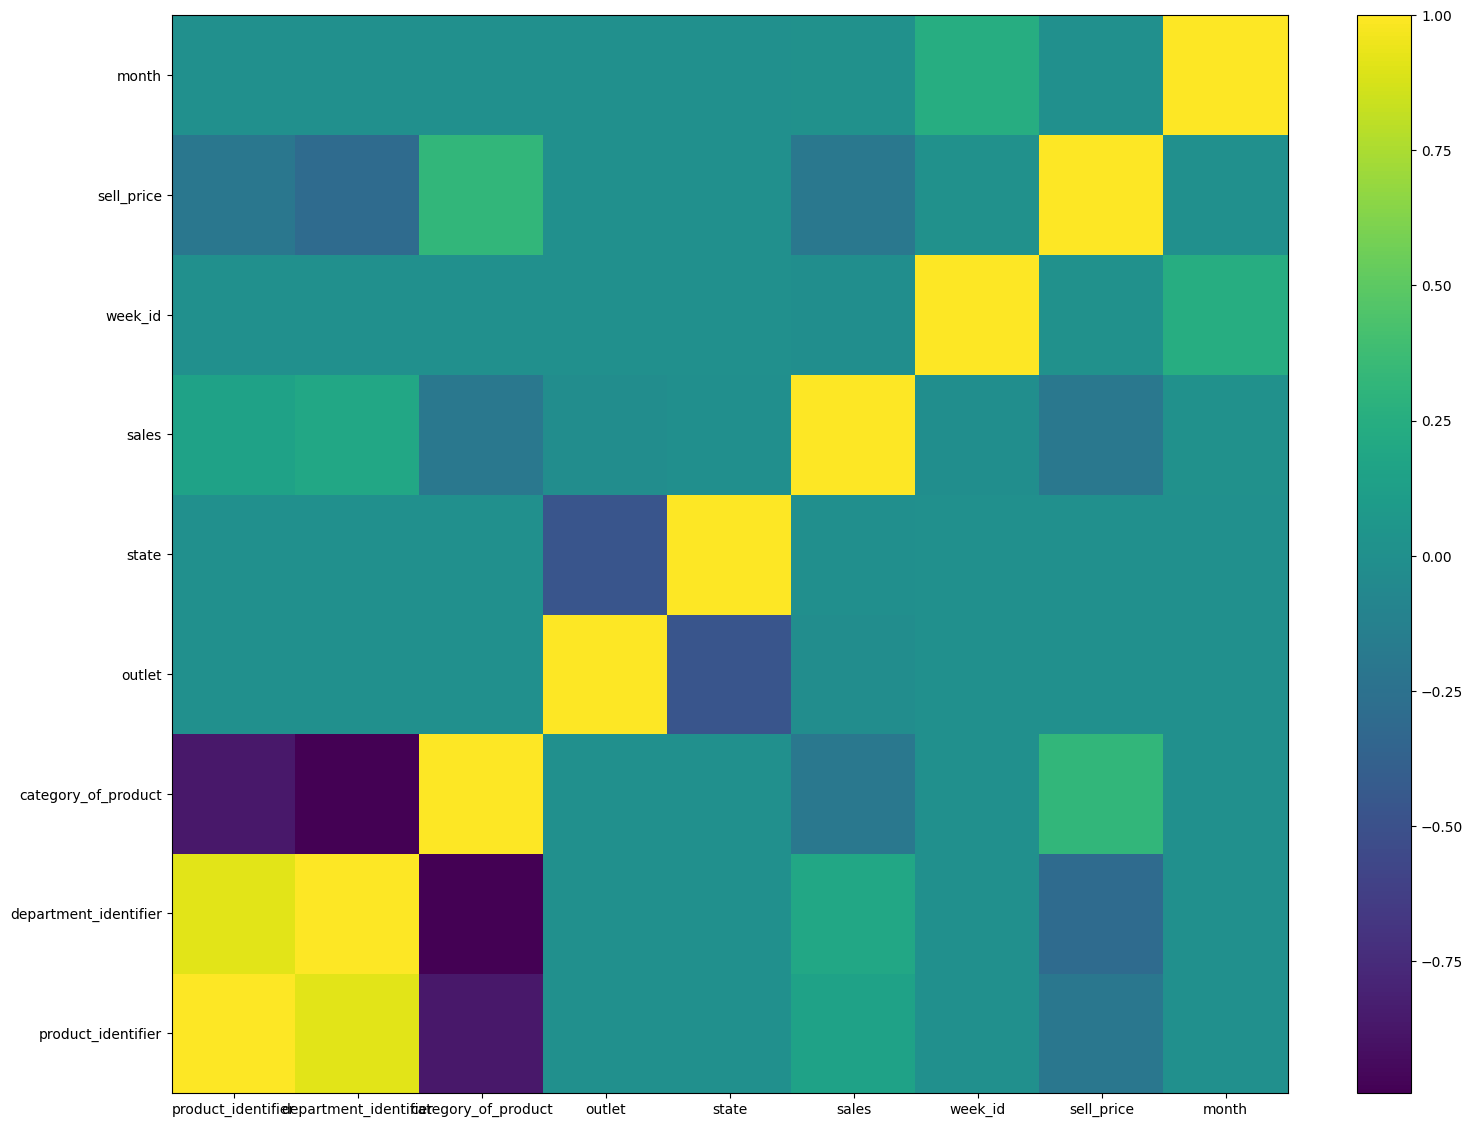

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 14))
corr = train_data.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
fig.colorbar(c)

# Define the target variable and the supporting variables

In [13]:
X=train_data[['product_identifier','department_identifier','category_of_product','outlet','state','week_id','sell_price','month']]
Y=train_data['sales']

# 5. Split the data into training and testing for the model fit

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train, Y_test=train_test_split(X,Y,test_size=0.3,random_state=1)

# 6. Import different models to check which is the most efficient one

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [16]:
models=[
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor()
]

# 7. Evaluate the models against each other

In [19]:
for model in models:
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        print(f"{model.__class__.__name__} RMSE:", rmse)

LinearRegression RMSE: 3.323778676880444
DecisionTreeRegressor RMSE: 2.7062580961320553
RandomForestRegressor RMSE: 2.655633498426335
KNeighborsRegressor RMSE: 2.651577669053105


# 8. Prepare the test data and perform all operations that were performed on training data

In [20]:
test_data = pd.read_csv(predicting_the_sales_of_products_of_a_retail_chain_path + '/test_data.csv')
merged_product_df = pd.merge(product_prices,date_to_week_id_map, on=['week_id'], how='inner')
test_data = pd.merge(test_data,merged_product_df, on=['date','product_identifier','outlet'], how='inner')
test_data
import datetime as dt
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['month']=test_data['date'].dt.month
test_data=test_data.drop(['date'],axis=1)
test_data.isna().sum()
##converting as category
col = ['category_of_product', 'state']
# Convert each column to category type and then access category codes
for col_name in col:
    test_data[col_name] = test_data[col_name].astype('category').cat.codes
    print(test_data[col_name])

0        2
1        2
2        2
3        2
4        1
        ..
15495    0
15496    0
15497    0
15498    0
15499    0
Name: category_of_product, Length: 15500, dtype: int8
0        1
1        1
2        1
3        1
4        1
        ..
15495    0
15496    0
15497    0
15498    0
15499    0
Name: state, Length: 15500, dtype: int8


In [21]:
test_data=test_data.drop('id',axis=1)
test_data.head(5)

,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,month
0,74,11,2,111,1,162,3.43,3
1,337,11,2,111,1,162,7.78,3
2,423,12,2,111,1,162,0.97,3
3,432,12,2,111,1,162,4.97,3
4,581,21,1,111,1,162,4.88,3


# 9.Run the model on the test data to predict the values for the target variable

In [22]:
model=RandomForestRegressor()
model.fit(X_train,Y_train)
X_test=test_data
Y_test_pred=model.predict(X_test)
print(Y_test_pred)
test_data['sales']=Y_test_pred
print("Predicted values:")
test_data.head(5)

[0.005      0.70605164 0.15108333 ... 0.05       1.5155     0.02244048]
Predicted values:


,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,month,sales
0,74,11,2,111,1,162,3.43,3,0.005000
1,337,11,2,111,1,162,7.78,3,0.706052
2,423,12,2,111,1,162,0.97,3,0.151083
3,432,12,2,111,1,162,4.97,3,0.000000
4,581,21,1,111,1,162,4.88,3,1.080333


# 10. Perform arithmetic on the target variable to convert it to int instead of float

In [23]:
test_data['sales']=np.round(test_data['sales']*10).astype(int)
test_data.head(5)

,product_identifier,department_identifier,category_of_product,outlet,state,week_id,sell_price,month,sales
0,74,11,2,111,1,162,3.43,3,0
1,337,11,2,111,1,162,7.78,3,7
2,423,12,2,111,1,162,0.97,3,2
3,432,12,2,111,1,162,4.97,3,0
4,581,21,1,111,1,162,4.88,3,11
